In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pickle
from time import time
from sklearn.cross_validation import train_test_split
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
# load csv files
train_df = pd.read_csv("train.csv")
profiles_df = pd.read_csv("profiles.csv")
artists_df = pd.read_csv("artists.csv")
artists_with_genres_df = pd.read_csv("artists_with_genres.csv")
user_median_df = pd.read_csv("user_median.csv")
global_median_df = pd.read_csv("global_median.csv")
training_df = pd.read_csv("training_df43.csv")

artist_with_top5_genre = pd.read_csv("artists_with_top_5_genres.csv")
# rename columns due to set_index offset issue
artist_with_top5_genre.rename(columns = {"num_votes5":"extra"}, inplace = True)
artist_with_top5_genre.rename(columns = {"genre5":"num_votes5"}, inplace = True)
artist_with_top5_genre.rename(columns = {"num_votes4":"genre5"}, inplace = True)
artist_with_top5_genre.rename(columns = {"genre4":"num_votes4"}, inplace = True)
artist_with_top5_genre.rename(columns = {"num_votes3":"genre4"}, inplace = True)
artist_with_top5_genre.rename(columns = {"genre3":"num_votes3"}, inplace = True)
artist_with_top5_genre.rename(columns = {"num_votes2":"genre3"}, inplace = True)
artist_with_top5_genre.rename(columns = {"genre2":"num_votes2"}, inplace = True)
artist_with_top5_genre.rename(columns = {"num_votes1":"genre2"}, inplace = True)
artist_with_top5_genre.rename(columns = {"genre1":"num_votes1"}, inplace = True)
artist_with_top5_genre.rename(columns = {"name":"genre1"}, inplace = True)
artist_with_top5_genre.rename(columns = {"artist":"name"}, inplace = True)
artist_with_top5_genre.head(3)

# Calculate percent of votes
agn = artist_with_top5_genre[["num_votes1","num_votes2"]]
agn = agn.apply(lambda c: c / c.sum() * 100, axis=1)
agn.rename(columns = {"num_votes1":"per_votes1"}, inplace = True)
agn.rename(columns = {"num_votes2":"per_votes2"}, inplace = True)

# combine dfs together
at5g = pd.concat([artist_with_top5_genre, agn], axis=1)

In [3]:
# calculate mean age per user
mean_age = profiles_df[~profiles_df['age'].isnull()]["age"].mean()

###################################################################### 

# calculate mean age per men
males_only_df = profiles_df[profiles_df["sex"]=='m']
mean_male_age = males_only_df[~males_only_df['sex'].isnull()]["age"].mean()

###################################################################### 

# calculate mean age per women
females_only_df = profiles_df[profiles_df["sex"]=='f']
mean_female_age = females_only_df[~females_only_df['sex'].isnull()]["age"].mean()

###################################################################### 

# get list of unique countries
countries = profiles_df["country"].unique()

# calculate mean age per country
mean_country_age = {}
for country in countries:
    tmp_df = profiles_df[profiles_df["country"]==str(country)]
    mean_country_age[str(country)] = tmp_df["age"].mean()

###################################################################### 
    
# calculate mean age per male per country
mean_country_male_age = {}
for country in countries:
    tmp_df0 = profiles_df[profiles_df["sex"]=='m']
    tmp_df1 = tmp_df0[profiles_df["country"]==str(country)]
    mean_country_male_age[str(country)] = tmp_df1["age"].mean()

###################################################################### 

# calculate mean age per female per country
mean_country_female_age = {}
for country in countries:
    tmp_df0 = profiles_df[profiles_df["sex"]=='f']
    tmp_df1 = tmp_df0[profiles_df["country"]==str(country)]
    mean_country_female_age[str(country)] = tmp_df1["age"].mean()


###################################################################### 

# initialize training df
training_df = profiles_df

###################################################################### 

# create sex indicators
training_df["male"] = 0
training_df["female"] = 0
training_df["sex_missing"] = 0
training_df.loc[training_df["sex"] =='m', "male"] = 1
training_df.loc[training_df["sex"] =='f', "female"] = 1
training_df.loc[training_df["sex"].isnull(), "sex_missing"] = 1

######################################################################  

# create age indicators
training_df["age_missing"] = 0
training_df.loc[training_df["age"].isnull(),"age_missing"] = 1

# fill in mean age: has no gender or country
training_df.loc[training_df["age_missing"] == 1, "age"] = mean_age

# fill in mean age: has gender, no country
#males
condition = (training_df["sex"] =='m') & (training_df["country"].isnull()) & (training_df["age_missing"] == 1)
training_df.loc[condition, "age"] = mean_male_age
# females
condition = (training_df["sex"] =='f') & (training_df["country"].isnull()) & (training_df["age_missing"] == 1)
training_df.loc[condition, "age"] = mean_female_age

# fill in mean age: has country, no gender
#loop over countries
for country in countries:
    condition = (training_df["country"] == country) & (training_df["age_missing"] == 1) & (training_df["sex_missing"] == 1)
    training_df.loc[condition, "age"] = mean_country_age[country]

# fill in mean age: has gender and country
# loop over countries
for country in countries:
    # males
    condition = (training_df["country"] == country) & (training_df["sex"] == 'm') & (training_df["age_missing"] == 1)
    training_df.loc[condition, "age"] = mean_country_male_age[country]
    # females
    condition = (training_df["country"] == country) & (training_df["sex"] == 'f') & (training_df["age_missing"] == 1)
    training_df.loc[condition, "age"] = mean_country_female_age[country]

###################################################################### 
    
# create country indicators
training_df["country_missing"] = 0
training_df.loc[training_df["country"].isnull(), "country_missing"] = 1
# loop over countries
for country in countries:
    # assign 1 if in that country
    training_df.loc[training_df["country"] == country, country] = 1
    # assign 0 otherwise
    training_df.loc[training_df["country"] != country, country] = 0

In [4]:
#training_df.to_csv("training_df43.csv")

In [5]:
train_df["genre1"] = np.nan
train_df = train_df.set_index("artist")
train_df.update(at5g)
train_df = train_df.reset_index()

In [19]:
user_genre_df = train_df.groupby(["user","genre1"]).mean().reset_index().set_index('user')
training_df = training_df.set_index("user")
user_genre_df = pd.concat([user_genre_df, training_df], axis=1, join_axes = [user_genre_df.index])
user_genre_index = user_genre_df.reset_index()

,genre1,plays,sex,age,country,male,female,sex_missing,age_missing,country_missing,...,Myanmar,Somalia,Gambia,Mozambique,Rwanda,Saint Kitts and Nevis,New Caledonia,Sudan,Guyana,Marshall Islands
user,,,,,,,,,,,,,,,,,,,,,
00000c289a1829a808ac09c00daf10bc3c4e223b,acoustic rock,182,f,22,Germany,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
00000c289a1829a808ac09c00daf10bc3c4e223b,british,361,f,22,Germany,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
00000c289a1829a808ac09c00daf10bc3c4e223b,celtic punk,302,f,22,Germany,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [21]:
# save df
#user_genre_df.to_csv("user_genre_df.csv")

In [29]:
def recompute_frame(ldf):
    """
    takes a dataframe ldf, makes a copy of it, and returns the copy
    with all averages and review counts recomputed
    this is used when a frame is subsetted.
    """
    ldfu = ldf.groupby('user')
    ldfg = ldf.groupby('genre1')
    user_avg = ldfu.plays.mean()
    user_genre_count = ldfu.genre1.count()
    genre_avg = ldfg.plays.mean()
    genre_user_count = ldfg.user.count()
    nldf = ldf.copy()
    nldf.set_index(['genre1'], inplace=True)
    nldf['genre_avg'] = genre_avg
    nldf['genre_user_count'] = genre_user_count
    nldf.reset_index(inplace=True)
    nldf.set_index(['user'], inplace=True)
    nldf['user_avg'] = user_avg
    nldf['user_genre_count'] = user_genre_count
    nldf.reset_index(inplace=True)
    return nldf

In [30]:
bigdf = recompute_frame(user_genre_df)

In [32]:
def compute_supports(df):
    uuids=df.user.unique()
    gens = df.groupby('genre1').user.unique()
    adict={}
    for e,v in zip(gens.index.values, gens.values):
        adict[e] = np.array([item in v for item in uuids])
    genres=adict.keys()
    supports=[]
    for i,gen1 in enumerate(genres):
        print "\r" + str(i) + " out of " + str(len(artists)),
        for j,gen2 in enumerate(genres):
            if  i < j:
                supmask = (adict[gen1] & adict[gen2])
                common_users = np.sum(supmask)
                supports.append(common_users)
    print "mean support",np.mean(supports), "median support", np.median(supports)
    return supports, adict

In [33]:
def make_smaller(df, genrecount, usercount):
    smallidf1=df[(df.genre_user_count > genrecount)]
    smallidf1=recompute_frame(smallidf1)
    smallidf2=smallidf1[(smallidf1.user_genre_count > usercount)]
    smalldf=recompute_frame(smallidf2)
    return smalldf

In [66]:
smalldf = make_smaller(smalldf, 9875, 10)

In [50]:
# save df
#smalldf.to_csv("smalldf.csv")

In [67]:
print "Number of user-genre combinations",smalldf.shape[0]
print "Number of users", smalldf.user.unique().shape[0]
print "Number of genres", smalldf.genre1.unique().shape[0]

Number of user-genre combinations 434735
Number of users 36250
Number of genres 43


In [71]:
uuids = smalldf.user.unique()
gens = smalldf.groupby('genre1').user.unique()
adict = {}
counter = 0
for e,v in zip(gens.index.values, gens.values):
    #if counter % 5 == 0:
    print str(counter) + " out of " + str(len(gens))
    counter +=1
    adict[e] = np.array([item in v for item in uuids])

0 out of 43
1 out of 43
2 out of 43
3 out of 43
4 out of 43
5 out of 43
6 out of 43
7 out of 43
8 out of 43
9 out of 43
10 out of 43
11 out of 43
12 out of 43
13 out of 43
14 out of 43
15 out of 43
16 out of 43
17 out of 43
18 out of 43
19 out of 43
20 out of 43
21 out of 43
22 out of 43
23 out of 43
24 out of 43
25 out of 43
26 out of 43
27 out of 43
28 out of 43
29 out of 43
30 out of 43
31 out of 43
32 out of 43
33 out of 43
34 out of 43
35 out of 43
36 out of 43
37 out of 43
38 out of 43
39 out of 43
40 out of 43
41 out of 43
42 out of 43


In [72]:
genres=adict.keys()
supports=[]
for i,gen1 in enumerate(genres):
    for j,gen2 in enumerate(genres):
        if  i < j:
            supmask = (adict[gen1] & adict[gen2])
            common_users = np.sum(supmask)
            supports.append(common_users)

print "mean support",np.mean(supports), "median support", np.median(supports)
s = supports
d = adict

mean support 2676.51384275 median support 1718.0


User genre plays mean and median 11.9926896552 12.0


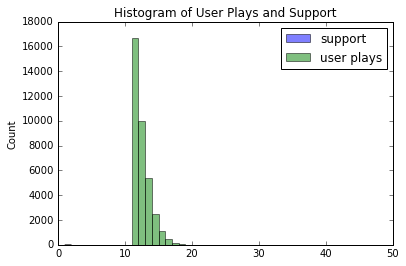

In [77]:
plt.hist(s, bins=np.arange(1,50,1), alpha=0.5, label="support");
c = smalldf.groupby('user').genre1.count()
print "User genre plays mean and median",np.mean(c), np.median(c)
plt.hist(c, bins=np.arange(1,50,1), alpha=0.5, label="user plays");
plt.legend();
plt.ylabel("Count")
plt.title("Histogram of User Plays and Support")
plt.show()

In [79]:
print smalldf.shape
smalldf=smalldf.drop_duplicates(['user','genre1'])
print smalldf.shape

(434735, 254)
(434735, 254)


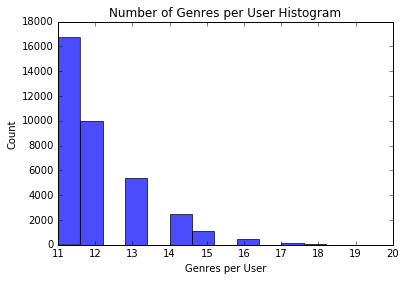

In [80]:
plt.hist(smalldf.groupby('user').count().user_genre_count,bins=15,alpha=0.7)
plt.xlabel("Genres per User")
plt.ylabel("Count")
plt.title("Number of Genres per User Histogram")
plt.show()

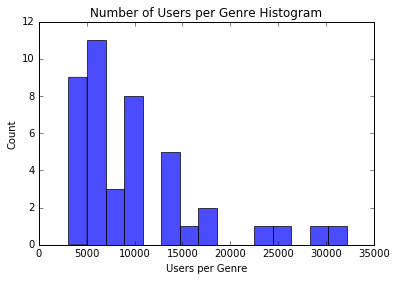

In [81]:
plt.hist(smalldf.groupby('genre1').count().genre_user_count,bins=15,alpha=0.7)
plt.xlabel("Users per Genre")
plt.ylabel("Count")
plt.title("Number of Users per Genre Histogram")
plt.show()

In [82]:
smalldf[smalldf.user_genre_count > 12].shape

(131262, 254)

In [83]:
trainlist=[]
testlist=[]
validatelist=[]
take=5
for k, v in smalldf.groupby('user'):
    if np.mean(v.user_genre_count) > 12:
        takenos=np.random.choice(range(take), size=take/2, replace=False)
        takelist=np.array([e in takenos for e in range(take)])
        validatelist.append(v[-take:][~takelist])#use those 
        testlist.append(v[-take:][takelist])#use the other 
        trainlist.append(v[:-take])
    else:
        trainlist.append(v)
traindf=pd.concat(trainlist)
validatedf=pd.concat(validatelist)
testdf=pd.concat(testlist)
print traindf.shape, validatedf.shape, testdf.shape

(386895, 254) (28704, 254) (19136, 254)


In [84]:
maskval=[e in set(validatedf.genre1).difference(set(traindf.genre1)) for e in validatedf.genre1] 
masktest=[e in set(testdf.genre1).difference(set(traindf.genre1)) for e in testdf.genre1] 
print np.sum(maskval), np.sum(masktest)

0 0
